In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.utils import shuffle
import time
import scipy.io
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh_prime(x):
    return 1 - np.tanh(x)**2

def relu_prime(x):
    return np.where(x > 0, 1, 0)

In [5]:
class QuadraticCost(object):
    @staticmethod
    def fn(a, y):
        return 0.5 * np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        return (a-y) * sigmoid_prime(z)

class CrossEntropyCost(object):
    @staticmethod
    def fn(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        return (a-y)

class Sigmoid(object):
    @staticmethod
    def activate(z):
        return 1.0/(1.0+np.exp(-z))

    @staticmethod
    def delta(z):
        return sigmoid(z)*(1-sigmoid(z))

class Tanh(object):
    @staticmethod
    def activate(z):
        return np.tanh(z)

    @staticmethod
    def delta(z):
        return 1.0 - np.tanh(z)**2

class ReLU(object):
    @staticmethod
    def activate(z):
        return np.maximum(0, z)

    @staticmethod
    def delta(z):
        return np.where(z > 0, 1, 0)

class Network(object):
    def __init__(self, sizes, cost=CrossEntropyCost, func=Sigmoid):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.weight_initializer()
        self.cost=cost
        self.func=func

    def weight_initializer(self):
        self.weights = [np.random.randn(y, x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = (self.func).activate(np.dot(w, a)+b)
        return a

    def train(self, training_data, epochs, learning_rate, save=False):
        n = len(training_data)
        log_file = open("log.txt", "w")  # records loss for each epoch
        log_file.write("Number of epochs: %d, Learning rate: %f\n" % (epochs, learning_rate))

        # perform gradient check using numerical approximation
        # self.gradient_check(training_data)

        # Initialize a list to store loss for each epoch
        losses = []

        for j in range(epochs):
            error_b = [np.zeros(b.shape) for b in self.biases]
            error_w = [np.zeros(w.shape) for w in self.weights]
            for (x, y) in training_data:
                delta_error_b, delta_error_w = self.backprop(x, y)
                error_b = [(eb+deb/n) for eb, deb in zip(error_b, delta_error_b)]
                error_w = [(ew+dew/n) for ew, dew in zip(error_w, delta_error_w)]

            loss = self.loss(training_data)
            log_file.write("Epoch %d: %f\n" % (j, loss))
            log_file.flush()  # Flush the file to disk after writing each line
            losses.append(loss)

            self.weights = [w-learning_rate*ew for w, ew in zip(self.weights, error_w)]
            self.biases = [b-learning_rate*eb for b, eb in zip(self.biases, error_b)]

        log_file.close()

        if save:
            self.save("model.txt")

    def backprop(self, x, y):
        error_b = [np.zeros(b.shape) for b in self.biases]
        error_w = [np.zeros(w.shape) for w in self.weights]
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = (self.func).activate(z)
            activations.append(activation)
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        error_w[-1] = np.dot(delta, activations[-2].transpose())
        error_b[-1] = delta
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = (self.func).delta(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            error_w[-l] = np.dot(delta, activations[-l-1].transpose())
            error_b[-l] = delta
        return (error_b, error_w)

    def loss(self, data):
        loss = 0
        for x, y in data:
            a = self.feedforward(x)
            # if convert: y = vectorized_result(y)
            loss += self.cost.fn(a, y)/len(data)
        return loss

    def save(self, filename):
        # save with the following format: sizes, weights, biases, cost, func line by line
        with open(filename, "w") as f:
            f.write("%s\n" % self.sizes)
            for w in self.weights:
                for row in w:
                    f.write("%s\n" % row)
            for b in self.biases:
                for row in b:
                    f.write("%s\n" % row)
            f.write("%s\n" % self.cost)
            f.write("%s\n" % self.func)
        f.close()

    def test(self, test_data, error=False):
        # print(self.feedforward(test_data[0][0]))
        test_results = [(1 if self.feedforward(x) > 0.5 else 0, y) for (x, y) in test_data]
        accuracy = np.mean([int(x == y) for (x, y) in test_results])
        # print("Accuracy: ", accuracy)
        # print(test_results)
        if error:
            return 1 - accuracy
        return accuracy


    def gradient_check(self, training_data):
        epsilon = 1e-7
        tolerance = 1e-3

        for x, y in training_data:
            backprop_b, backprop_w = self.backprop(x, y)

            for i in range(len(self.biases)):
                for j in range(len(self.biases[i])):
                    original_bias = self.biases[i][j]
                    self.biases[i][j] += epsilon
                    loss_plus = self.loss([(x, y)])
                    self.biases[i][j] -= 2*epsilon
                    loss_minus = self.loss([(x, y)])
                    self.biases[i][j] = original_bias
                    numerical_gradient = (loss_plus - loss_minus) / (2*epsilon)

                    if abs(numerical_gradient - backprop_b[i][j]) > tolerance:
                        print("Gradient check failed for bias[%d][%d]: %f vs %f" % (i, j, numerical_gradient, backprop_b[i][j]))

            for i in range(len(self.weights)):
                for j in range(len(self.weights[i])):
                    for k in range(len(self.weights[i][j])):
                        original_weight = self.weights[i][j][k]
                        self.weights[i][j][k] += epsilon
                        loss_plus = self.loss([(x, y)])
                        self.weights[i][j][k] -= 2*epsilon
                        loss_minus = self.loss([(x, y)])
                        self.weights[i][j][k] = original_weight
                        numerical_gradient = (loss_plus - loss_minus) / (2*epsilon)

                        if abs(numerical_gradient - backprop_w[i][j][k]) > tolerance:
                            print("Gradient check failed for weight[%d][%d][%d]: %f vs %f" % (i, j, k, numerical_gradient, backprop_w[i][j][k]))

def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [6]:
def load_network():
    file = open("network.txt", "r")
    # format: sizes, cost function, activation function each on a separate line
    sizes = list(map(int, file.readline().split()))

    # Read the cost function and activation function names
    cost_fn_name = file.readline().strip()
    activation_fn_name = file.readline().strip()

    # Mapping of cost function names to classes
    cost_fn_mapping = {
        "QuadraticCost": QuadraticCost,
        "CrossEntropyCost": CrossEntropyCost
    }

    # Mapping of activation function names to classes
    activation_fn_mapping = {
        "Sigmoid": Sigmoid,
        "Tanh": Tanh
    }

    # Get the actual classes based on the names read from the file
    cost_fn = cost_fn_mapping.get(cost_fn_name, CrossEntropyCost)  # Default to CrossEntropyCost if not found
    activation_fn = activation_fn_mapping.get(activation_fn_name, Sigmoid)  # Default to Sigmoid if not found

    # Initialize the network with the correct classes
    net = Network(sizes, cost=cost_fn, func=activation_fn)
    print(sizes, cost_fn_name, activation_fn_name)
    return net

## Word to Vector

In order to download the word2vec file go to https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g and download teh file which is 1.5GB!. Then place the downloaded file in the current directory and the proceed with the execution of the following cells.

In [7]:

import gensim
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [8]:
# Load the pre-trained Word2Vec model
model_path = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz'
w2v_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [9]:
# def get_vector_of_sentence(sentence, model):
#     words = sentence.split()
#     vector = np.zeros(model.vector_size)
#     valid_words = 0
#     for word in words:
#         if word in model.key_to_index:  # Use .key_to_index for checking if a word is in the model
#             vector += model[word]
#             valid_words += 1
#     if valid_words:
#         vector /= valid_words
#     return vector

In [10]:
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Ensure you have downloaded the necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

def get_vector_of_sentence(sentence, model):
    # Initialize a lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Convert sentence to lowercase and split into words
    words = sentence.lower().split()

    # Filter out stopwords
    filtered_words = [word for word in words if word not in stopwords.words('english')]

    vector = np.zeros(model.vector_size)
    total_words = 0

    for word in filtered_words:
        # Lemmatize the word
        lemmatized_word = lemmatizer.lemmatize(word)
        total_words += 1

        if lemmatized_word in model.key_to_index:  # Check if the lemmatized word is in the model
            vector += model.get_vector(lemmatized_word)

    if total_words > 0:
        vector /= total_words

    return vector

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Load SST2 Dataset and make the required adjustments

In [1]:
!pip install datasets
!pip install --upgrade datasets pyarrow
# from datasets import load_dataset
# ds = load_dataset("stanfordnlp/sst2")

from datasets import load_dataset
ds = load_dataset("cornell-movie-review-data/rotten_tomatoes")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 require

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [11]:
from datasets import concatenate_datasets
combined_dataset = concatenate_datasets([ds['train'], ds['validation'], ds['test']])

In [12]:
# Vectorize all sentences
# sentence_vectors = [get_vector_of_sentence(item['sentence'], w2v_model) for item in combined_dataset]
sentence_vectors = [get_vector_of_sentence(item['text'], w2v_model) for item in combined_dataset]

# Extract labels
labels = [item['label'] for item in combined_dataset]

# Split into training and test sets
X_train_sentence, X_test_sentence, y_train, temp_y_test = train_test_split(sentence_vectors, labels, test_size=0.2, random_state=42)

# Convert lists to NumPy arrays for compatibility with many ML libraries
X_train = np.array(X_train_sentence)
y_train = np.array(y_train)
X_test = np.array(X_test_sentence)
y_test = np.array(temp_y_test)

test_inputs = [np.reshape(x, (len(x), 1)) for x in X_test_sentence]
test_results = [np.reshape(y, (1, 1)) for y in temp_y_test]
test_data = list(zip(test_inputs, test_results))

training_data = list(zip(X_train, y_train))

In [13]:
len(X_train[0])

300

## Sentiment Analysis

In [ ]:
len(training_data)

8529

In [ ]:
net = Network([300, 100, 100, 1], cost=CrossEntropyCost, func=Sigmoid)

In [ ]:
n = len(training_data)
k = 128

initial_eta = 0.1
decay_rate = 0.99
decay_step = 250
decay = 0.0001
etas = []
iterations = 0
losses = []
previous_loss = 0
iteration_time = []

In [ ]:
import pickle
variables = {
    'net': net,
    'etas': etas,
    'losses': losses,
    'iterations': iterations,
    'iteration_time': iteration_time
}

In [ ]:
# before = net.test(test_data)
# np.random.seed(42)
while True:
    time1 = time.process_time()
    random_seed = random.randint(0, n)
    np.random.seed(random_seed)
    indices = np.random.choice(n, k, replace=False)
    temp_X_train = X_train[indices]
    temp_y_train = y_train[indices]
    training_inputs = [np.reshape(x, (len(x), 1)) for x in temp_X_train]
    training_results = [np.reshape(y, (1, 1)) for y in temp_y_train]
    temp_training_data = list(zip(training_inputs, training_results))
    if(iterations % 100 == 0):
      print(f"iteration {iterations}")
      print(f"Training Accuracy: {net.test(temp_training_data)}")
      print(f"Test Accuracy: {net.test(test_data)}")
      print("--------------------------------------------------------")

    # eta = initial_eta / (1 + decay * iterations)
    eta = initial_eta * decay_rate ** (iterations / decay_step)
    net.train(temp_training_data, 1, eta)
    # net.train(training_data, 1, eta)
    temp = Network.loss(net, training_data)
    losses.append(temp)
    # if abs(temp - previous_loss) < 1e-7 or iterations == 8000:
    #     break
    etas.append(eta)
    if(iterations == 4000):
       break
    previous_loss = temp
    iterations += 1
    time2 = time.process_time()
    iteration_time.append(time2 - time1)
    with open('networkcopy.pkl', 'wb') as f:
      pickle.dump(variables, f)

print("Number of iterations: ", iterations)
print("Average iteration time: ", np.mean(iteration_time))
print("Total time: ", np.sum(iteration_time))
plt.figure()
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
after = net.test(test_data)
# print(before)
print(after)
plt.figure()
plt.plot(etas)
plt.xlabel('Iteration')
plt.ylabel('ETA')
plt.title('ETA plot')
plt.show()

iteration 0
Training Accuracy: 0.4609375
Test Accuracy: 0.4927332395686826
--------------------------------------------------------
iteration 100
Training Accuracy: 0.515625
Test Accuracy: 0.5860290670417253
--------------------------------------------------------
iteration 200
Training Accuracy: 0.671875
Test Accuracy: 0.6118143459915611
--------------------------------------------------------
iteration 300
Training Accuracy: 0.671875
Test Accuracy: 0.6305672761368963
--------------------------------------------------------
iteration 400
Training Accuracy: 0.5859375
Test Accuracy: 0.6371308016877637
--------------------------------------------------------
iteration 500
Training Accuracy: 0.7265625
Test Accuracy: 0.6408813877168308
--------------------------------------------------------
iteration 600
Training Accuracy: 0.7109375
Test Accuracy: 0.653539615564932
--------------------------------------------------------
iteration 700
Training Accuracy: 0.578125
Test Accuracy: 0.655414908

KeyboardInterrupt: 

iteration 2800
Training Accuracy: 0.6796875
Test Accuracy: 0.7191748710736052
--------------------------------------------------------
iteration 2900
Training Accuracy: 0.734375
Test Accuracy: 0.7107360525082044
--------------------------------------------------------
iteration 3000
Training Accuracy: 0.7578125
Test Accuracy: 0.7083919362400375
--------------------------------------------------------
iteration 3100
Training Accuracy: 0.71875
Test Accuracy: 0.7224566338490389
--------------------------------------------------------
iteration 3200
Training Accuracy: 0.75
Test Accuracy: 0.7191748710736052
--------------------------------------------------------
iteration 3300
Training Accuracy: 0.7109375
Test Accuracy: 0.7177684013127051
--------------------------------------------------------
iteration 3400
Training Accuracy: 0.6796875
Test Accuracy: 0.7238631036099391
--------------------------------------------------------
iteration 3500
Training Accuracy: 0.84375
Test Accuracy: 0.7172

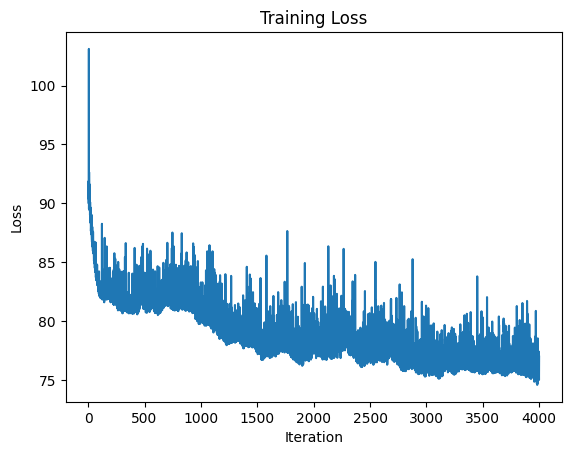

0.7187060478199718


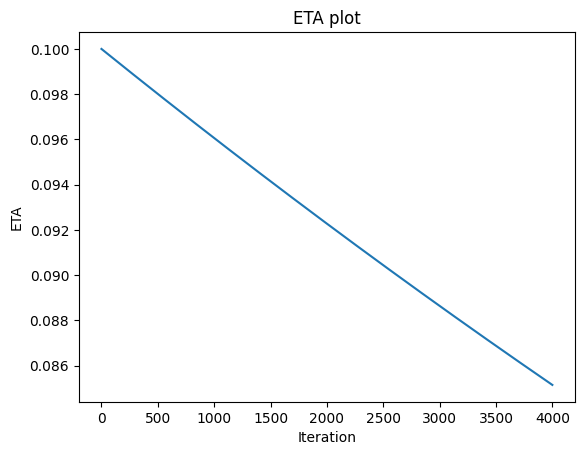

In [18]:
# before = net.test(test_data)
# np.random.seed(42)
while True:
    time1 = time.process_time()
    random_seed = random.randint(0, n)
    np.random.seed(random_seed)
    indices = np.random.choice(n, k, replace=False)
    temp_X_train = X_train[indices]
    temp_y_train = y_train[indices]
    training_inputs = [np.reshape(x, (len(x), 1)) for x in temp_X_train]
    training_results = [np.reshape(y, (1, 1)) for y in temp_y_train]
    temp_training_data = list(zip(training_inputs, training_results))
    if(iterations % 100 == 0):
      print(f"iteration {iterations}")
      print(f"Training Accuracy: {net.test(temp_training_data)}")
      print(f"Test Accuracy: {net.test(test_data)}")
      print("--------------------------------------------------------")

    # eta = initial_eta / (1 + decay * iterations)
    eta = initial_eta * decay_rate ** (iterations / decay_step)
    net.train(temp_training_data, 1, eta)
    # net.train(training_data, 1, eta)
    temp = Network.loss(net, training_data)
    losses.append(temp)
    # if abs(temp - previous_loss) < 1e-7 or iterations == 8000:
    #     break
    etas.append(eta)
    if(iterations == 4000):
       break
    previous_loss = temp
    iterations += 1
    time2 = time.process_time()
    iteration_time.append(time2 - time1)
    with open('networkcopy.pkl', 'wb') as f:
      pickle.dump(variables, f)

print("Number of iterations: ", iterations)
print("Average iteration time: ", np.mean(iteration_time))
print("Total time: ", np.sum(iteration_time))
plt.figure()
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
after = net.test(test_data)
# print(before)
print(after)
plt.figure()
plt.plot(etas)
plt.xlabel('Iteration')
plt.ylabel('ETA')
plt.title('ETA plot')
plt.show()

In [ ]:
net = Network([300, 100, 100, 1], cost=CrossEntropyCost, func=Sigmoid)

In [ ]:
n = len(training_data)
k = 128

initial_eta = 0.1
decay_rate = 0.99
decay_step = 250
decay = 0.0001
etas = []
iterations = 0
losses = []
previous_loss = 0
iteration_time = []

In [ ]:
import pickle
variables = {
    'net': net,
    'etas': etas,
    'losses': losses,
    'iterations': iterations,
    'iteration_time': iteration_time
}

iteration 0
Training Accuracy: 0.5546875
Test Accuracy: 0.5119549929676512
--------------------------------------------------------
iteration 100
Training Accuracy: 0.640625
Test Accuracy: 0.5893108298171589
--------------------------------------------------------
iteration 200
Training Accuracy: 0.6171875
Test Accuracy: 0.6240037505860291
--------------------------------------------------------
iteration 300
Training Accuracy: 0.6640625
Test Accuracy: 0.6624472573839663
--------------------------------------------------------
iteration 400
Training Accuracy: 0.6328125
Test Accuracy: 0.6751054852320675
--------------------------------------------------------
iteration 500
Training Accuracy: 0.65625
Test Accuracy: 0.6854195968120019
--------------------------------------------------------
iteration 600
Training Accuracy: 0.6796875
Test Accuracy: 0.6858884200656352
--------------------------------------------------------
iteration 700
Training Accuracy: 0.6796875
Test Accuracy: 0.6844819

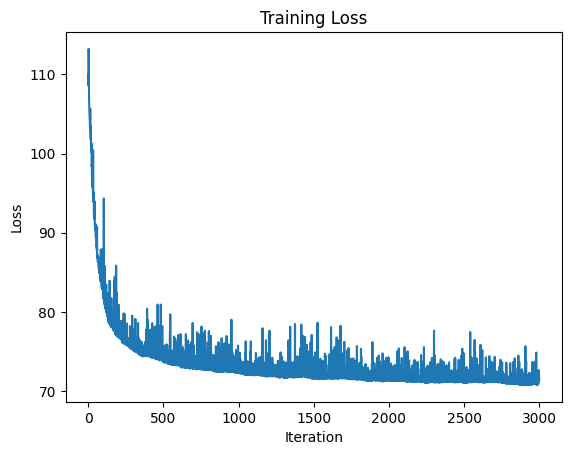

0.7332395686826066


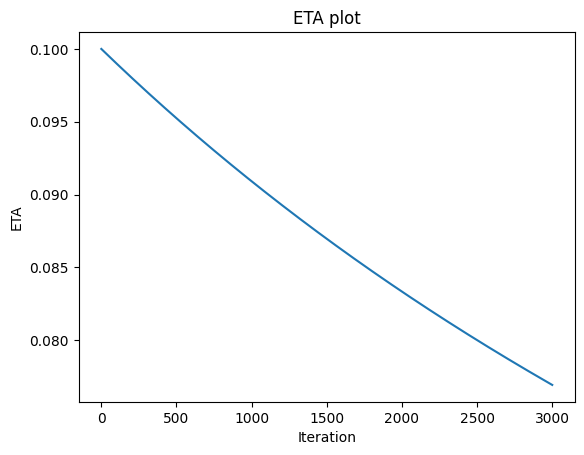

In [ ]:
# before = net.test(test_data)
# np.random.seed(42)
while True:
    time1 = time.process_time()
    random_seed = random.randint(0, n)
    np.random.seed(random_seed)
    indices = np.random.choice(n, k, replace=False)
    temp_X_train = X_train[indices]
    temp_y_train = y_train[indices]
    training_inputs = [np.reshape(x, (len(x), 1)) for x in temp_X_train]
    training_results = [np.reshape(y, (1, 1)) for y in temp_y_train]
    temp_training_data = list(zip(training_inputs, training_results))
    if(iterations % 100 == 0):
      print(f"iteration {iterations}")
      print(f"Training Accuracy: {net.test(temp_training_data)}")
      print(f"Test Accuracy: {net.test(test_data)}")
      print("--------------------------------------------------------")

    eta = initial_eta / (1 + decay * iterations)
    # eta = initial_eta * decay_rate ** (iterations / decay_step)
    net.train(temp_training_data, 1, eta)
    # net.train(training_data, 1, eta)
    temp = Network.loss(net, training_data)
    losses.append(temp)
    # if abs(temp - previous_loss) < 1e-7 or iterations == 8000:
    #     break
    etas.append(eta)
    if(iterations == 3000):
       break
    previous_loss = temp
    iterations += 1
    time2 = time.process_time()
    iteration_time.append(time2 - time1)
    with open('networkcopy.pkl', 'wb') as f:
      pickle.dump(variables, f)

print("Number of iterations: ", iterations)
print("Average iteration time: ", np.mean(iteration_time))
print("Total time: ", np.sum(iteration_time))
plt.figure()
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
after = net.test(test_data)
# print(before)
print(after)
plt.figure()
plt.plot(etas)
plt.xlabel('Iteration')
plt.ylabel('ETA')
plt.title('ETA plot')
plt.show()

In [ ]:
# use pickle library to save the variables
import pickle
variables = {
    'net': net,
    'etas': etas,
    'losses': losses,
    'iterations': iterations,
    'iteration_time': iteration_time
}
with open('networkcopy.pkl', 'wb') as f:
    pickle.dump(variables, f)

In [14]:
import pickle
with open('networkcopy.pkl', 'rb') as f:
    variables = pickle.load(f)

net = variables['net']
etas = variables['etas']
losses = variables['losses']
iterations = variables['iterations']
iteration_time = variables['iteration_time']

In [15]:
iterations = len(losses)
n = len(training_data)
k = 128

initial_eta = 0.1
decay_rate = 0.99
decay_step = 250
decay = 0.0001

In [ ]:
temp = get_vector_of_sentence("The movie was disappointing", w2v_model)
temp = np.reshape(temp, (len(temp), 1))
prediction = net.feedforward(temp)
print(prediction)
if prediction >= 0:
    print("Positive")
else:
    print("Negative")